In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly

In [34]:
data = pd.read_csv(r'revenue.csv')

In [35]:
df = pd.DataFrame(data)
data['week'] = pd.to_datetime(data['week'], dayfirst=True, errors='coerce')
df = df.rename(columns={"week": "ds", "revenue": "y"})
df

In [36]:
# Convert the 'ds' column to datetime
df['ds'] = pd.to_datetime(df['ds'], dayfirst=True, errors='coerce')
df.set_index('ds', inplace=True)
df = df['y'].resample('W-MON').sum().reset_index()
df = df.sort_values(by='ds', ascending=False)
df

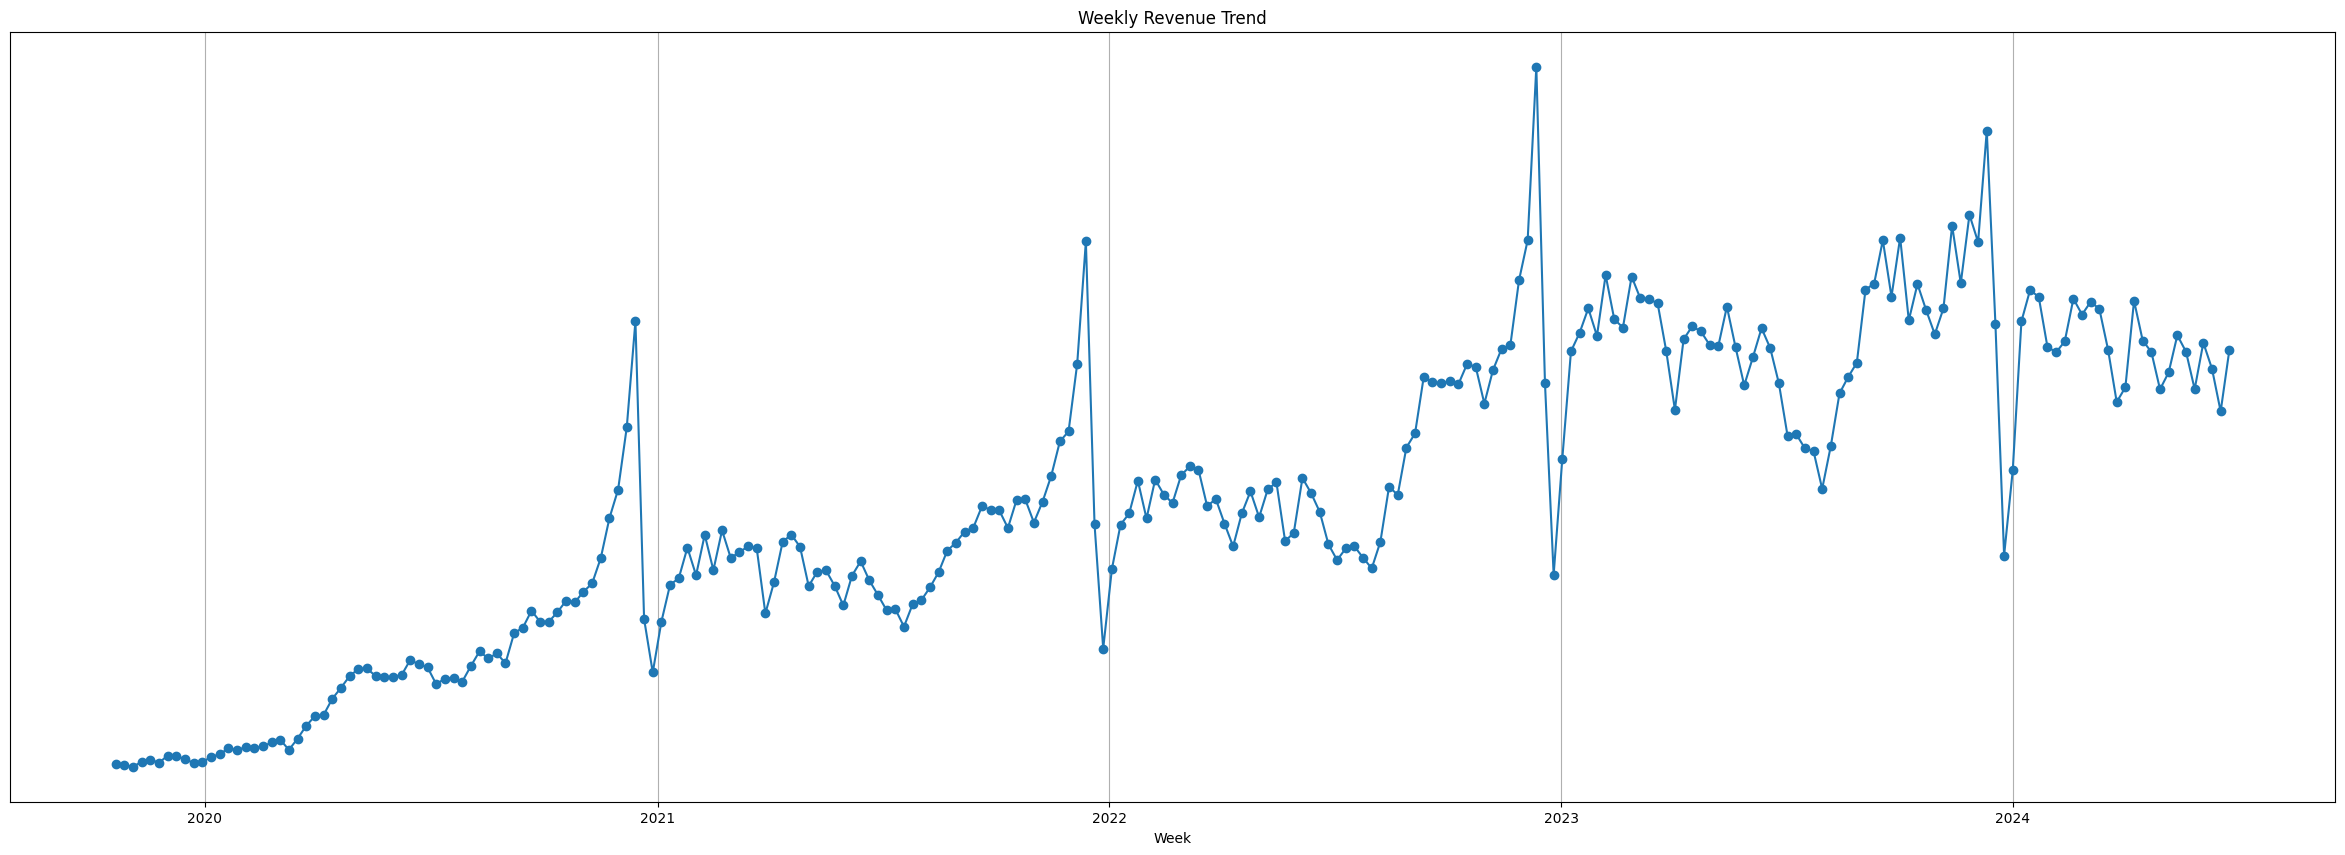

In [37]:
plt.figure(figsize=(30, 10))
plt.plot(df['ds'], df['y'], marker='o')
plt.title('Weekly Revenue Trend')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.gca().axes.yaxis.set_visible(False)
plt.grid(True)
plt.show()

In [38]:
split_idx = int(len(df) * 0.15)  # 85% for training
test = df.iloc[:split_idx]
train = df.iloc[split_idx:]

In [41]:
model = Prophet(
    growth='linear',
    yearly_seasonality=10,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_prior_scale=10,
    holidays_prior_scale=0.1,
    changepoint_prior_scale=0.1,
    interval_width=0.95,
    seasonality_mode='multiplicative'
)

model.add_country_holidays(country_name='US')
model.add_seasonality(
    name='monthly',
    period=30,
    fourier_order=5  # Maintain or adjust based on component plots
)

# If incorporating a rolling average as an additional regressor
train['rolling_avg'] = train['y'].rolling(window=4).mean()  # 4 could be any number appropriate for your data
train = train.fillna(0)
model.add_regressor('rolling_avg')
model.fit(train)

/var/folders/4t/x_mp7lnd0rdf8pw92lx11mhw0000gn/T/ipykernel_91388/3304795305.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

23:31:18 - cmdstanpy - INFO - Chain [1] start processing
23:31:18 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# After fitting the model, perform cross-validation and calculate new performance metrics
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='90 days')
df_p = performance_metrics(df_cv)
print(df_p[['horizon', 'mae', 'rmse', 'coverage']])

In [ ]:
length = len(test)
window_size = 4  # Or another value that suits your data
train['rolling_avg'] = train['y'].rolling(window=window_size).mean()
future = model.make_future_dataframe(periods=length, freq='W-MON')

initial_values = train['rolling_avg'].tail(window_size).tolist()
future['rolling_avg'] = pd.Series([None] * len(future))

# Set the first few values of the future's rolling_avg with the last known values from train
for i in range(min(window_size, len(future))):
    future.loc[i, 'rolling_avg'] = initial_values[i % len(initial_values)]

# Forward fill the rest of the future's rolling_avg
future['rolling_avg'] = future['rolling_avg'].ffill()

print(future)


In [44]:
# Predict using the future dataframe
forecast = model.predict(future)

In [60]:
def fit_and_predict(df, interval_width, x):
    model = Prophet(interval_width=interval_width)
    model.fit(df)
    future = model.make_future_dataframe(periods=x, freq='W-MON')
    forecast = model.predict(future)
    return model, forecast

In [61]:
model_90, forecast_90 = fit_and_predict(train, 0.90, length)
model_95, forecast_95 = fit_and_predict(train, 0.95, length)
model_99, forecast_99 = fit_and_predict(train, 0.99, length)

23:33:51 - cmdstanpy - INFO - Chain [1] start processing
23:33:51 - cmdstanpy - INFO - Chain [1] done processing
23:33:51 - cmdstanpy - INFO - Chain [1] start processing
23:33:51 - cmdstanpy - INFO - Chain [1] done processing
23:33:51 - cmdstanpy - INFO - Chain [1] start processing
23:33:51 - cmdstanpy - INFO - Chain [1] done processing


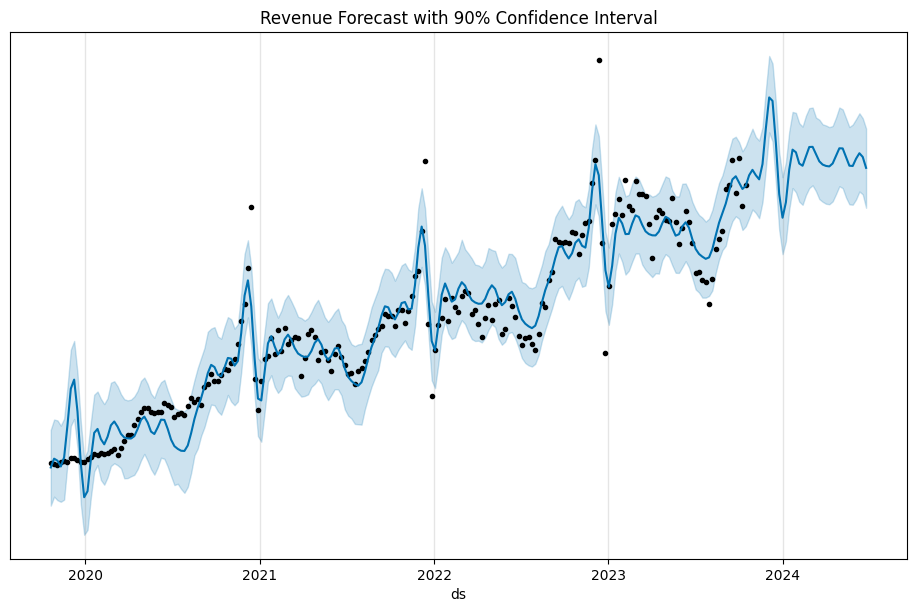

In [62]:
fig_90 = model_90.plot(forecast_90)
plt.title('Revenue Forecast with 90% Confidence Interval')
plt.gca().axes.yaxis.set_visible(False)
plt.show()

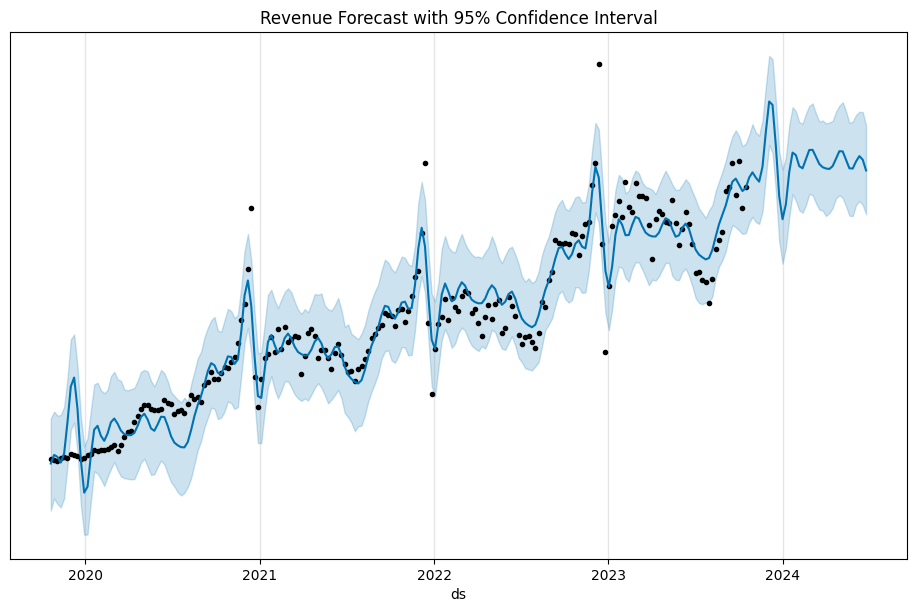

In [63]:
fig_95 = model_95.plot(forecast_95)
plt.title('Revenue Forecast with 95% Confidence Interval')
plt.gca().axes.yaxis.set_visible(False)
plt.show()

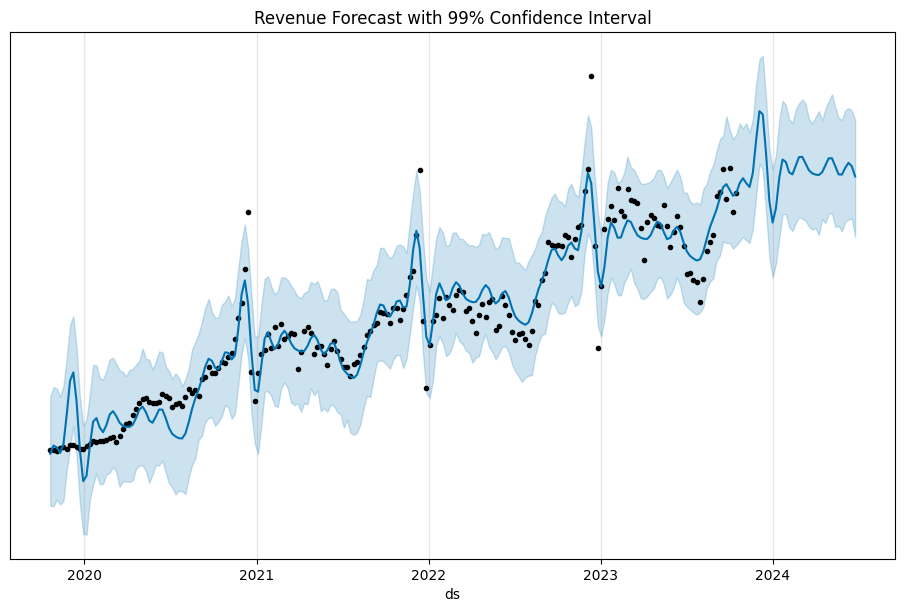

In [64]:
fig_99 = model_99.plot(forecast_99)
plt.title('Revenue Forecast with 99% Confidence Interval')
plt.gca().axes.yaxis.set_visible(False)
plt.show()

In [ ]:
forecast

In [ ]:
forecast_95

In [ ]:
predicted_values = forecast.tail(length)
predicted_values = forecast[['ds', 'yhat']]
predicted_values

In [ ]:
predicted_values_95 = forecast_95.tail(length)
predicted_values_95 = forecast_95[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
predicted_values_95

In [ ]:
comparison_df = pd.merge(test, predicted_values, how='inner', on='ds')
comparison_df.tail(38)

In [ ]:
comparison_df_95 = pd.merge(test, predicted_values_95, how='inner', on='ds')
comparison_df_95.tail(length)

In [71]:
mae = mean_absolute_error(comparison_df['y'], comparison_df['yhat'])
rmse = np.sqrt(mean_squared_error(comparison_df['y'], comparison_df['yhat']))
# Print out the error metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 8895.383022887072
Root Mean Squared Error (RMSE): 10607.017013696024


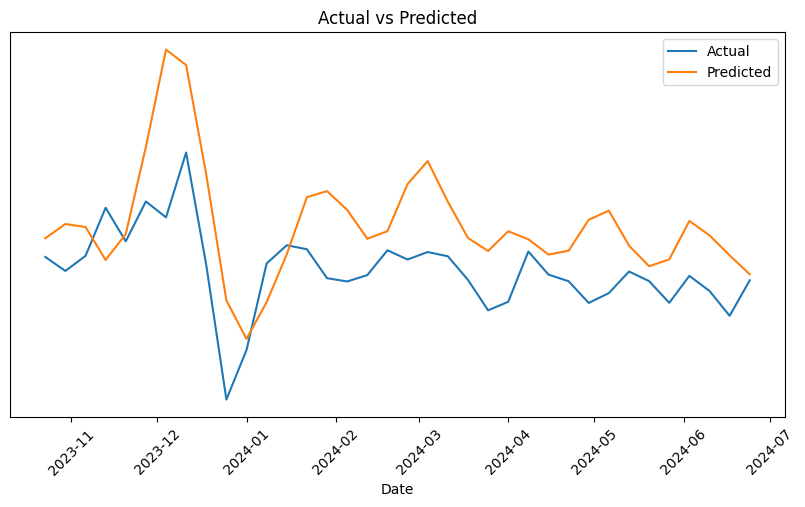

In [73]:
plt.figure(figsize=(10, 5))
plt.plot(comparison_df['ds'], comparison_df['y'], label='Actual')
plt.plot(comparison_df['ds'], comparison_df['yhat'], label='Predicted')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.gca().axes.yaxis.set_visible(False)
plt.legend()
plt.show()

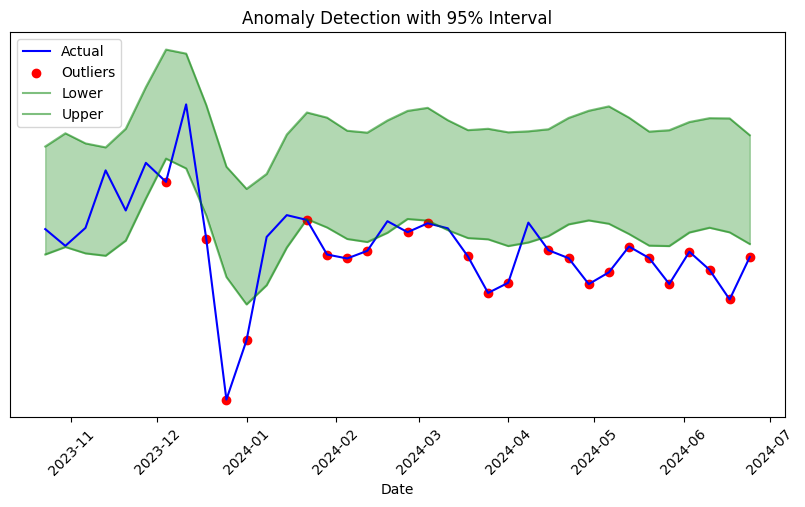

In [74]:
# Assuming comparison_df_95 is already defined and contains the necessary columns

# Create a mask for points outside the safety area
outliers = (comparison_df_95['y'] < comparison_df_95['yhat_lower']) | (comparison_df_95['y'] > comparison_df_95['yhat_upper'])

plt.figure(figsize=(10, 5))

# Plot the actual data
plt.plot(comparison_df_95['ds'], comparison_df_95['y'], label='Actual', color='blue')

# Fill the safety area with gradient color
plt.fill_between(comparison_df_95['ds'], comparison_df_95['yhat_lower'], comparison_df_95['yhat_upper'], color='green', alpha=0.3)

# Mark outliers
plt.scatter(comparison_df_95[outliers]['ds'], comparison_df_95[outliers]['y'], color='red', label='Outliers')

# Plot lower and upper bounds
plt.plot(comparison_df_95['ds'], comparison_df_95['yhat_lower'], color='green', alpha=0.5, label='Lower')
plt.plot(comparison_df_95['ds'], comparison_df_95['yhat_upper'], color='green', alpha=0.5, label='Upper')

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Value')
plt.gca().axes.yaxis.set_visible(False)
plt.title('Anomaly Detection with 95% Interval')
plt.legend()
plt.show()

In [76]:
import pandas as pd
import plotly.graph_objs as go

# Create a mask for points outside the safety area
outliers = (comparison_df_95['y'] < comparison_df_95['yhat_lower']) | (comparison_df_95['y'] > comparison_df_95['yhat_upper'])

# Create the plot
fig = go.Figure()

# Add actual revenue line
fig.add_trace(go.Scatter(x=comparison_df_95['ds'], y=comparison_df_95['y'], mode='lines', name='Actual', line=dict(color='blue')))

# Add safety area
fig.add_trace(go.Scatter(
    x=pd.concat([comparison_df_95['ds'], comparison_df_95['ds'][::-1]]),
    y=pd.concat([comparison_df_95['yhat_upper'], comparison_df_95['yhat_lower'][::-1]]),
    fill='toself',
    fillcolor='rgba(0, 255, 0, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=False,
    name='Safety Area'
))

# Add lower and upper bounds
fig.add_trace(go.Scatter(x=comparison_df_95['ds'], y=comparison_df_95['yhat_lower'], mode='lines', name='Lower', line=dict(color='green', dash='dash')))
fig.add_trace(go.Scatter(x=comparison_df_95['ds'], y=comparison_df_95['yhat_upper'], mode='lines', name='Upper', line=dict(color='green', dash='dash')))

# Add outliers
fig.add_trace(go.Scatter(x=comparison_df_95[outliers]['ds'], y=comparison_df_95[outliers]['y'], mode='markers', name='Outliers', marker=dict(color='red', size=8)))

# Update layout
fig.update_layout(
    title='Anomaly Detection with 95% Interval',
    xaxis_title='Week',
    yaxis_title='Value',
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
    template='plotly_white'
)

# Show the plot
fig.update_layout(yaxis=dict(visible=False))
fig.show()